# Project Description
This project focuses on the classification of satellite imagery into 2 classes, "wildfire" or "no wildfire". The dataset used for this project comes from the Kaggle dataset “Wildfire Prediction Dataset (Satellite Images)” and was sourced from the Canadian Government’s Forest Fires Open Data Portal. It includes satellite images of size 350x350 pixels categorized into two classes :
- Wildfire: 22,710 images
- No Wildfire: 20,140 images

To facilitate training, the dataset was split into:
- Train: ~70%
- Validation: ~15%
- Test: ~15%

The original goal of the project was to develop a custom convolutional neural network (CNN) capable of classifying whether a given image represents a wildfire area or not. The custom model is compared with other model: a data-augmentation–based CNN. These models could assist in rapid wildfire detection and risk analysis from new satellite images.

# Extensions made in this work after the original code

In addition to the original CNN-based pipeline, we further extended the project in four directions:

ConvLSTM integration: we introduced a ConvLSTM-based model that treats each satellite image as a sequence of length 1, i.e. input shape (time=1, H, W, C). Even though the current dataset is single-frame, this design makes the pipeline compatible with future multi-temporal satellite data (e.g. multi-day or multi-layer inputs) while still allowing us to train on the existing images.

Stronger training pipeline: we added on-the-fly data augmentation (random flip, rotation, zoom), input rescaling, and class weighting to compensate for small class imbalance between “wildfire” and “no wildfire.” This helped the model reach high validation accuracy quickly and reduced the tendency to always predict the majority class.

Robust data loading: some images in the dataset were partially corrupted (truncated JPEGs). We modified the TensorFlow data pipeline to ignore unreadable samples so that training would not crash, and we provided a script to detect and remove bad images.

Model comparison and analysis: we trained both CNN baselines and the ConvLSTM model on the same splits and compared them using confusion matrices, per-class precision/recall/F1, and threshold sweeps. On this purely spatial dataset, CNN models slightly outperformed ConvLSTM in wildfire recall, but the ConvLSTM architecture remains advantageous when temporal information is available, since it preserves spatial structure while modeling time.

This turns the project from a simple “which CNN wins in wildfire?” experiment into something a bit more interesting: we show that the same wildfire dataset can also host a spatiotemporal model. By dropping in a ConvLSTM and feeding each image as a 1-step sequence, we kept today’s single-frame setup working, but unlocked tomorrow’s use case — when satellite data arrive as short time series instead of isolated pictures. In other words, the CNNs tell us how well we can classify right now, while the ConvLSTM shows how this pipeline could grow into forecasting spread, change, or risk when multi-time-step imagery becomes available.

# Imports


In [8]:
# Global imports
import os
import random

# Handling data imports
import numpy as np
import pandas as pd
import cv2
from PIL import ImageFile

# Visualization imports
import matplotlib.pyplot as plt

# Deep learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import albumentations as transform

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print("Modules loaded successfully !")

2025-11-08 16:31:54.190485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762619514.433695      33 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762619514.503795      33 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modules loaded successfully !


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Data processing

In [10]:
# Define the directories of each set
dir = '/kaggle/input/wildfire-prediction-dataset'
train_dir = '/kaggle/input/wildfire-prediction-dataset/train'
val_dir = '/kaggle/input/wildfire-prediction-dataset/valid'
test_dir = '/kaggle/input/wildfire-prediction-dataset/test'

print("Directories defined !")

Directories defined !


In [11]:
# Function to display a sample of the satellite images of each set
def display_random_sample(dataset_dir):
    classes = os.listdir(dataset_dir)  # List of class directories
    plt.figure(figsize=(10, 10))       # Adjust the figure size if needed

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)                # Get all images in the class folder
        random_image = random.choice(image_files)          # Select a random image
        img_path = os.path.join(class_dir, random_image)

        # Load the image with its original size
        img = load_img(img_path)

        # Display the image
        plt.subplot(1, len(classes), i + 1)                       # Display images in a single row
        plt.imshow(img)
        plt.axis('off')                                           # Turn off axis for better visualization
        plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")  # Show class name and image size

    plt.show()

Training set contains 30250 images : 15750 wildfire and 14500 nowildfire images.


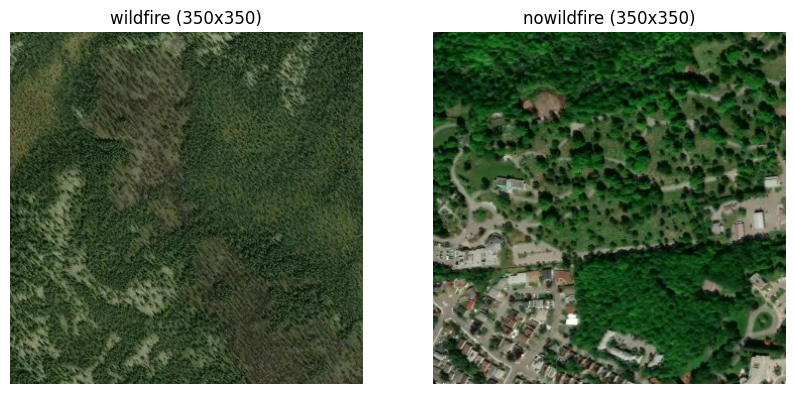

Validation set contains 6300 images : 3480 wildfire and 2820 nowildfire images.


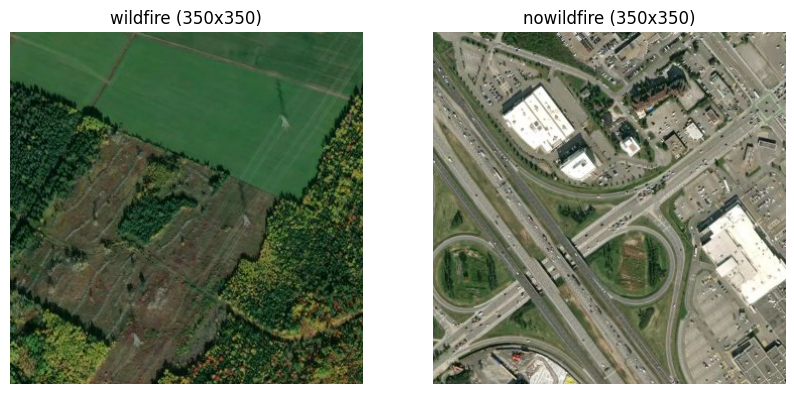

Test set contains 6300 images : 3480 wildfire and 2820 nowildfire images.


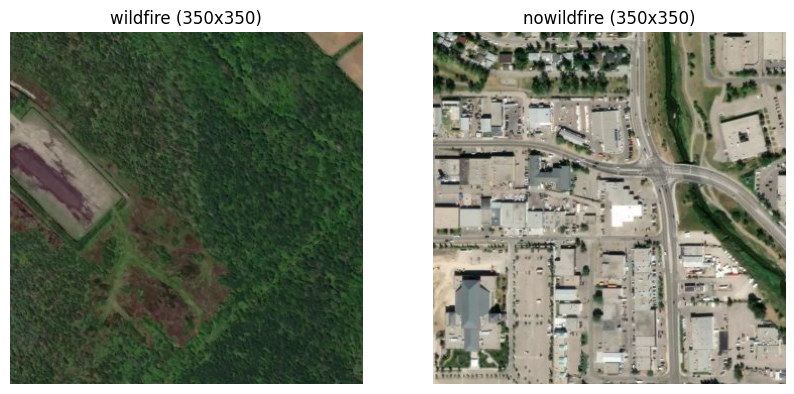

In [12]:
# Display the samples and computing size of sets
num_wf_train = len(os.listdir(os.path.join(train_dir,"wildfire")))
num_nwf_train = len(os.listdir(os.path.join(train_dir,"nowildfire")))
print(f"Training set contains {num_wf_train+num_nwf_train} images : {num_wf_train} wildfire and {num_nwf_train} nowildfire images.")
display_random_sample(train_dir)

num_wf_val = len(os.listdir(os.path.join(val_dir,"wildfire")))
num_nwf_val = len(os.listdir(os.path.join(val_dir,"nowildfire")))
print(f"Validation set contains {num_wf_val+num_nwf_val} images : {num_wf_val} wildfire and {num_nwf_val} nowildfire images.")
display_random_sample(val_dir)

num_wf_test = len(os.listdir(os.path.join(test_dir,"wildfire")))
num_nwf_test = len(os.listdir(os.path.join(test_dir,"nowildfire")))
print(f"Test set contains {num_wf_test+num_nwf_test} images : {num_wf_test} wildfire and {num_nwf_test} nowildfire images.")
display_random_sample(test_dir)

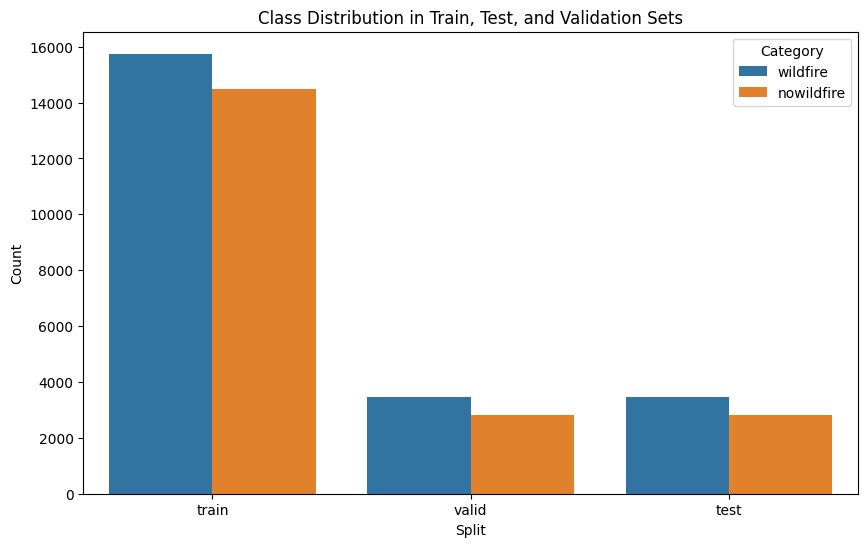

In [13]:
#### Plot class distribution : to be modified to display the distibution in my case
def plot_class_distribution(data_dir, splits, categories):

    image_counts = {}

    for split in splits:
        for category in categories:
            key = f"{split}_{category}"
            path = os.path.join(data_dir, split, category)
            image_counts[key] = len(os.listdir(path))

    data = []
    for split in splits:
        for category in categories:
            count = image_counts[f"{split}_{category}"]
            data.append({'Split': split, 'Category': category, 'Count': count})

    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Split', y='Count', hue='Category', data=df)
    plt.title('Class Distribution in Train, Test, and Validation Sets')
    plt.show()

splits = ['train', 'valid', 'test']
categories = ['wildfire', 'nowildfire']
plot_class_distribution(dir, splits, categories)

In [15]:
# Rescaling and loading the data
BATCH_SIZE = 32
TARGET_SIZE = (128,128)

datagen = ImageDataGenerator(dtype = 'float32', rescale = 1./255.)
train_generator = datagen.flow_from_directory(train_dir,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

val_generator = datagen.flow_from_directory(val_dir,
                                                   shuffle = False,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

test_generator = datagen.flow_from_directory(test_dir,
                                                   shuffle = False,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


# Data Augmentation

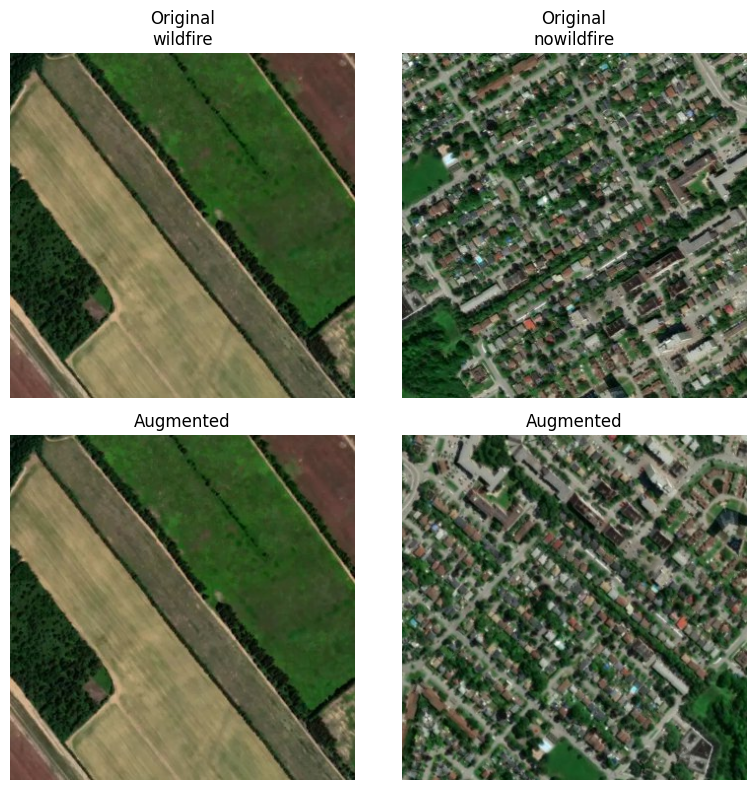

In [16]:
# Augmented data
def augmentation_image(image):
  aug = transform.Compose([
        transform.HorizontalFlip(p=0.5),
        transform.VerticalFlip(p=0.5),
        transform.Rotate(limit=75, always_apply = True, border_mode=cv2.BORDER_REFLECT_101)
    ])
  return aug(image=image)['image']

def display_augmented_sample(dataset_dir):
  classes = os.listdir(dataset_dir)           # List of class directories
  plt.figure(figsize=(len(classes) * 4, 8))   # Width scales with number of classes

  for i, class_name in enumerate(classes):
      class_dir = os.path.join(dataset_dir, class_name)
      image_files = os.listdir(class_dir)
      random_image = random.choice(image_files)
      img_path = os.path.join(class_dir, random_image)

      # Load image
      image_bgr = cv2.imread(img_path)
      image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
      augmented_image = augmentation_image(image_rgb)

      # Plot original
      plt.subplot(2, len(classes), i + 1)
      plt.imshow(image_rgb)
      plt.axis('off')
      plt.title(f"Original\n{class_name}")

      # Plot augmented
      plt.subplot(2, len(classes), i + 1 + len(classes))
      plt.imshow(augmented_image)
      plt.axis('off')
      plt.title("Augmented")

  plt.tight_layout()
  plt.show()

display_augmented_sample(train_dir)

In [17]:
# Rescaling and loading the augemnted data
datagen_augm_train = ImageDataGenerator(dtype = 'float32', rescale = 1./255., preprocessing_function = augmentation_image)
train_generator_augm = datagen_augm_train.flow_from_directory(train_dir,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

datagen_augm_test = ImageDataGenerator(dtype = 'float32', rescale = 1./255.)
val_generator_augm = datagen_augm_test.flow_from_directory(val_dir,
                                                   shuffle = False,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

test_generator_augm = datagen_augm_test.flow_from_directory(test_dir,
                                                   shuffle = False,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


# Creation of Models

1. build the model with Sequential API : used when we have one input that goes from top to bottom to one output
2. add layer to our model following an architecture like such :
    - Conv2D(number_filter, size_filter(pixel,pixel), stride, activation, padding(keep the same size as the previous layer), input_shape) : performs convolution operation.
    - MaxPooling2D(pool_size = 2) : takes the maximum value and condense the information.
    - Flatten : condenses and flatten the information to a single value.
    - Dense(number_neurons, activation) : fully connected layers.
    - Dropout : modifies the propagation probabilty of the signals of neurons.
    - BatchNormalization : applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
3. compile the model by telling it how to learn (Adam optimizer + binary_crossentropy loss) and what to report (accuracy, recall).     

In [18]:
# Model 1 : Simple Model (baseline)
weight_decay = 1e-3

def create_baseline_model():
  model = Sequential()

  model.add(Conv2D(8, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(16 , (3, 3), activation = 'relu', padding='same',))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(32 , (3, 3), activation = 'relu', kernel_regularizer = regularizers.l2(weight_decay) ))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Dropout(0.4)),
  model.add(Flatten())
  model.add(Dense(200,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1,activation='sigmoid'))

  # Visualize the model
  model.summary()

  # Compile the model
  model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4, decay= 1e-5),
              metrics=['accuracy','recall'])

  return model

model1 = create_baseline_model()

2025-11-08 16:34:34.815544: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       1,440,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,446,657 (5.52 MB)

 Trainable params: 1,446,545 (5.52 MB)

 Non-trainable params: 112 (448.00 B)

In [19]:
# Model 3 : Data Augmentation Model
model3 = create_baseline_model()
Model: "sequential_1"

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │       1,440,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,446,657 (5.52 MB)

 Trainable params: 1,446,545 (5.52 MB)

 Non-trainable params: 112 (448.00 B)

# Train the model
- training : images used for the training step
- epochs : how many times the model is going to go over the whole dataset
- validation : images used for the validation step
- callbacks : everything that is done after the passing of one epoch
    - EarlyStopping : stop the training if validation loss didn't decrease for 5 consecutive epochs
- verbose : to see how the model progresses during training

In [20]:
# Train the model 1 : baseline
ImageFile.LOAD_TRUNCATED_IMAGES = True

early_stopping = EarlyStopping(monitor= 'val_loss', patience= 2)

history1 = model1.fit(train_generator,
                    epochs = 3,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [early_stopping]
                   )

Epoch 1/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 417s 433ms/step - accuracy: 0.8752 - loss: 0.3868 - recall: 0.8876 - val_accuracy: 0.9476 - val_loss: 0.1654 - val_recall: 0.9661
Epoch 2/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 224s 236ms/step - accuracy: 0.9282 - loss: 0.2090 - recall: 0.9418 - val_accuracy: 0.9565 - val_loss: 0.1485 - val_recall: 0.9635
Epoch 3/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 221s 233ms/step - accuracy: 0.9361 - loss: 0.1855 - recall: 0.9486 - val_accuracy: 0.9598 - val_loss: 0.1410 - val_recall: 0.9693


In [21]:
# Train the model 3 : augmented data
history3 = model3.fit(train_generator_augm,
                    epochs = 3,
                    verbose = 1,
                    validation_data = val_generator_augm,
                    callbacks = [early_stopping]
                   )

Epoch 1/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 269s 277ms/step - accuracy: 0.8784 - loss: 0.3762 - recall: 0.8918 - val_accuracy: 0.9403 - val_loss: 0.1812 - val_recall: 0.9420
Epoch 2/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 238s 251ms/step - accuracy: 0.9184 - loss: 0.2306 - recall: 0.9305 - val_accuracy: 0.9452 - val_loss: 0.1720 - val_recall: 0.9503


# Visualize the results

In [23]:
# Display the graph of chosen metric
def plot_metrics(hist, metric_train, metric_val) :
  fig = plt.figure()
  plt.plot(hist.history[metric_train], color='teal', label=metric_train)
  plt.plot(hist.history[metric_val], color='orange', label=metric_val)
  fig.suptitle(metric_train, fontsize=20)
  plt.legend(loc="upper left")
  plt.show()

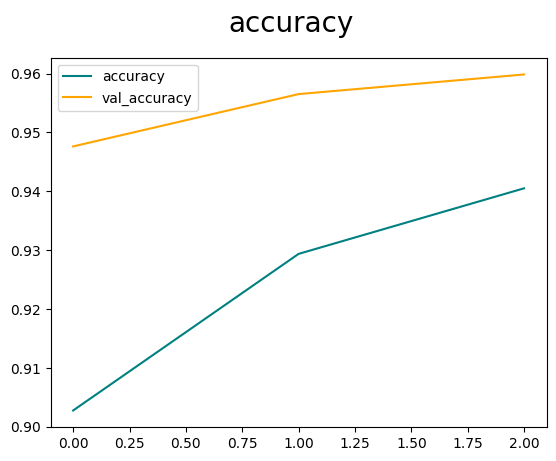

In [24]:
plot_metrics(history1, 'accuracy', 'val_accuracy')

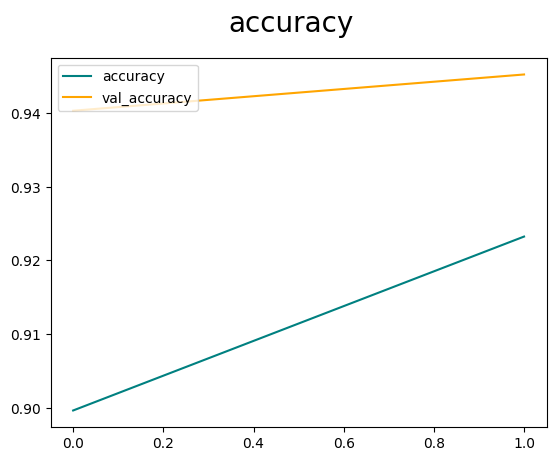

In [25]:
plot_metrics(history3, 'accuracy', 'val_accuracy')

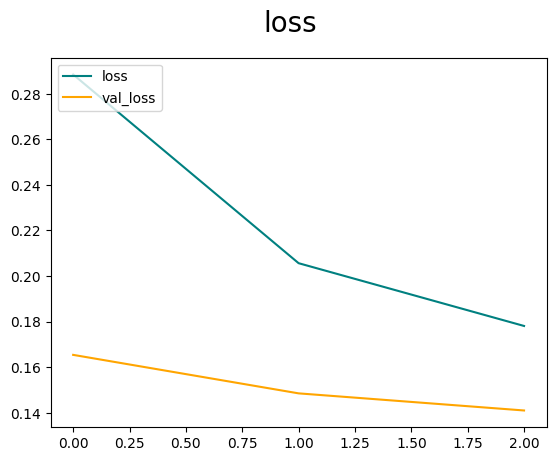

In [26]:
plot_metrics(history1, 'loss', 'val_loss')

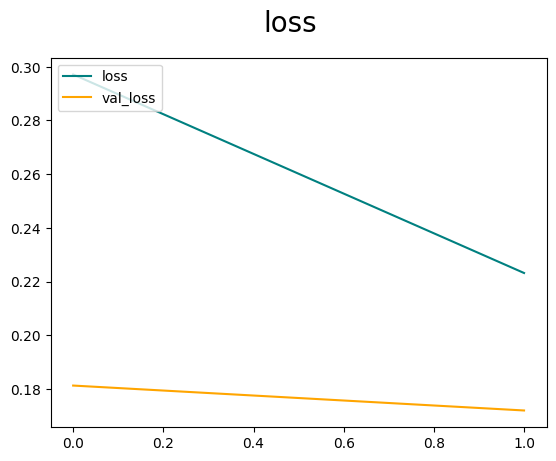

In [27]:
plot_metrics(history3, 'loss', 'val_loss')

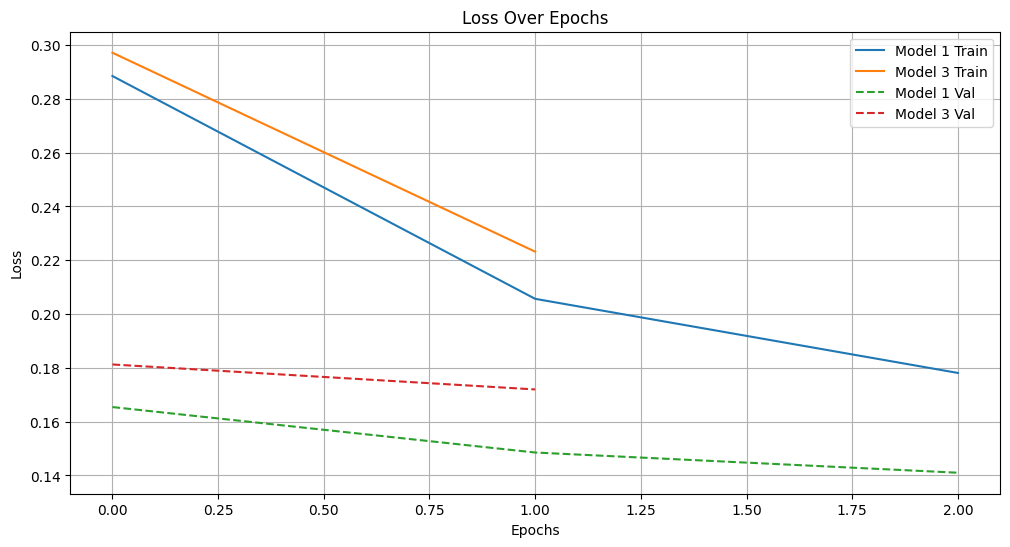

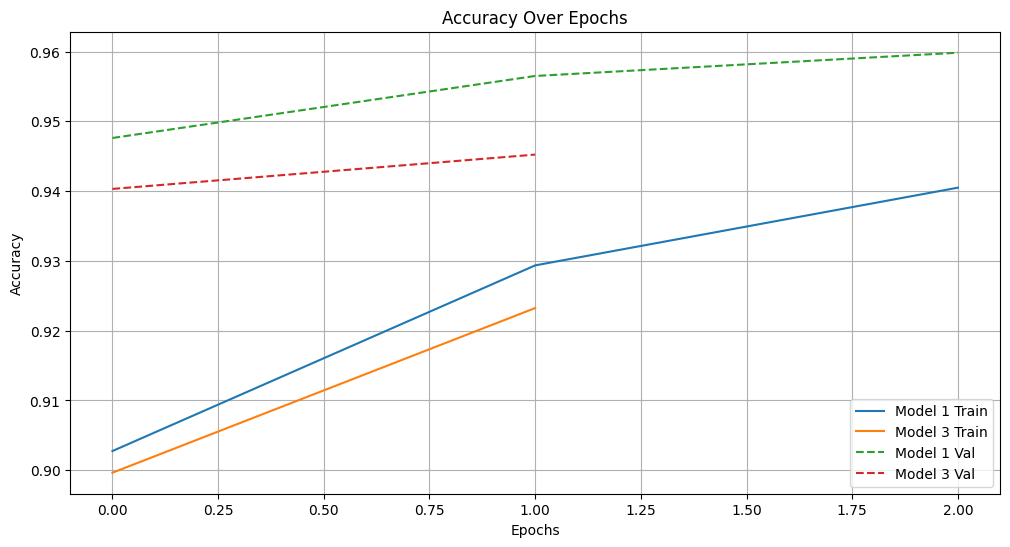

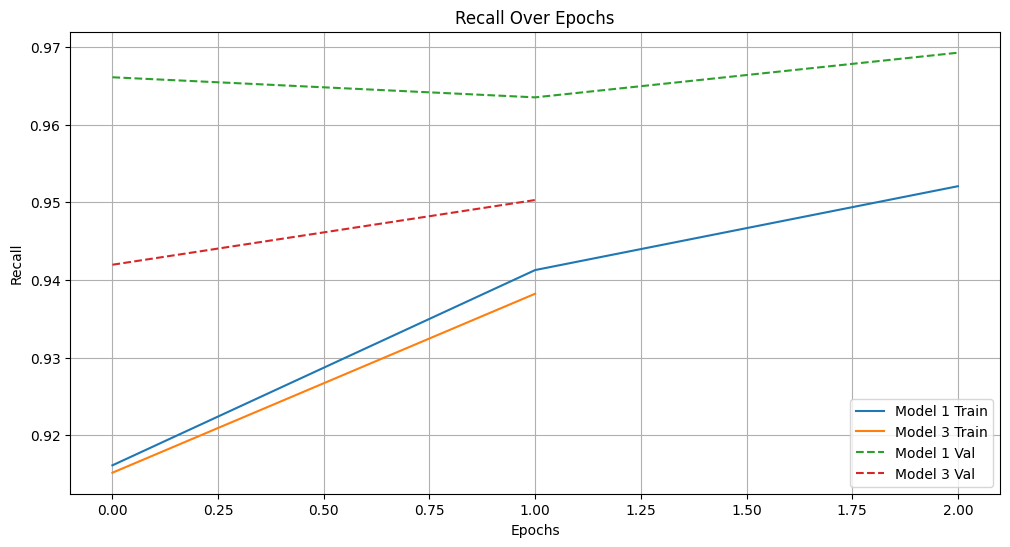

In [28]:
# Display the metrics of all models in the same graph

# List of history objects and labels
histories = [history1, history3]
labels = ['Model 1', 'Model 3']

# Define metrics to plot
metrics = ['loss', 'accuracy', 'recall']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))

    # Plot training metric
    for i, history in enumerate(histories):
        plt.plot(history.history[metric], label=f'{labels[i]} Train')

    # Plot validation metric
    for i, hist in enumerate(histories):
        plt.plot(hist.history[f'val_{metric}'], linestyle='--', label=f'{labels[i]} Val')

    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


In [30]:
# Function to plot some random predictions
def plot_random_pred(true_classes, predicted_classes, class_labels, filepaths) :
  # To hold selected indices
  correct_indices = {}
  incorrect_indices = {}

  # Search through predictions
  for idx, (true, pred) in enumerate(zip(true_classes, predicted_classes)):
      if true == pred and true not in correct_indices:
          correct_indices[true] = idx
      elif true != pred and true not in incorrect_indices:
          incorrect_indices[true] = idx
      if len(correct_indices) == len(class_labels) and len(incorrect_indices) == len(class_labels):
          break  # Stop once we have one of each per class

  # Plot
  plt.figure(figsize=(12, 6))
  for i, class_id in enumerate(range(len(class_labels))):
      # Correct
      idx = correct_indices.get(class_id)
      if idx is not None:
          img = load_img(filepaths[idx], target_size=TARGET_SIZE)
          plt.subplot(2, len(class_labels), i+1)
          plt.imshow(img)
          plt.axis('off')
          plt.title(f"{class_labels[class_id]}", color='green')

      # Incorrect
      idx = incorrect_indices.get(class_id)
      if idx is not None:
          img = load_img(filepaths[idx], target_size=TARGET_SIZE)
          plt.subplot(2, len(class_labels), i+1+len(class_labels))
          plt.imshow(img)
          plt.axis('off')
          plt.title(f"True: {class_labels[true_classes[idx]]}\nPred: {class_labels[predicted_classes[idx]]}", color='red')

  plt.tight_layout()
  plt.show()

# Evaluation of the models and Result analysis

197/197 ━━━━━━━━━━━━━━━━━━━━ 67s 338ms/step


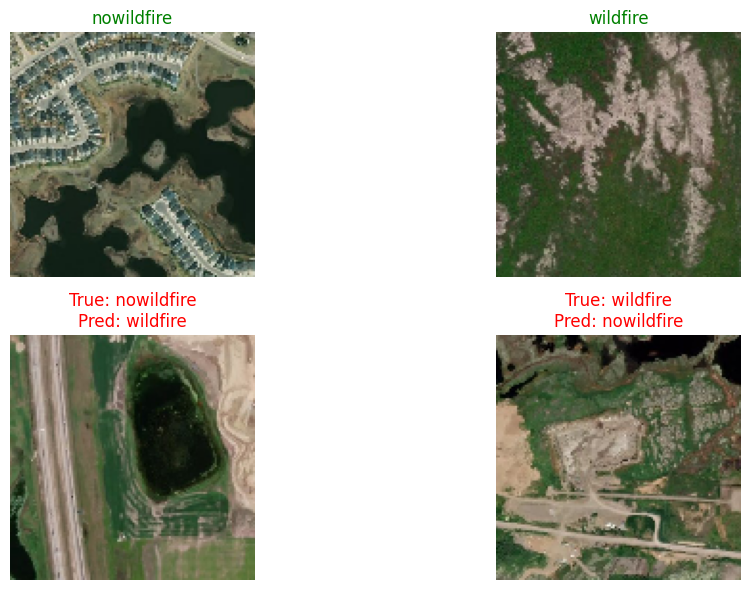

In [31]:
# Model 1
test_generator.reset()

filepaths = test_generator.filepaths
predictions = model1.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_random_pred(true_classes, predicted_classes, class_labels, filepaths)

In [33]:
# Model 3
test_generator_augm.reset()

filepaths3 = test_generator_augm.filepaths
predictions3 = model3.predict(test_generator_augm, verbose=1)
predicted_classes3 = (predictions3 > 0.5).astype("int32").flatten()
true_classes3 = test_generator_augm.classes
class_labels3 = list(test_generator_augm.class_indices.keys())

197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step


In [35]:
# Confusion matrix
def class_report(true_classes, predicted_classes, class_labels) :
  cm = confusion_matrix(true_classes, predicted_classes)

  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()

  # Classification report
  print(classification_report(true_classes, predicted_classes, target_names=class_labels))

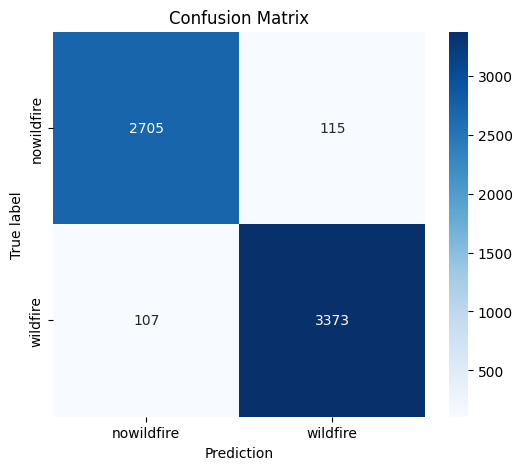

              precision    recall  f1-score   support

  nowildfire       0.96      0.96      0.96      2820
    wildfire       0.97      0.97      0.97      3480

    accuracy                           0.96      6300
   macro avg       0.96      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300



In [36]:
# Model 1
class_report(true_classes, predicted_classes, class_labels)

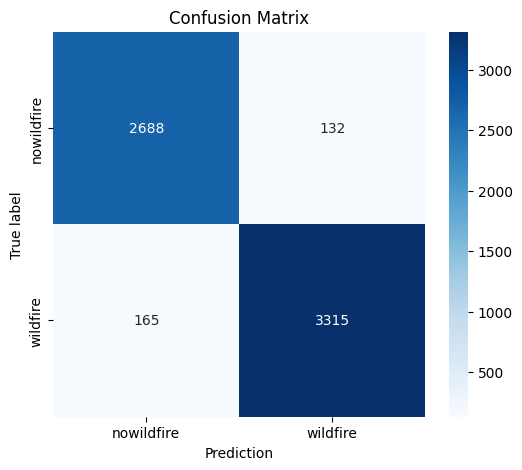

              precision    recall  f1-score   support

  nowildfire       0.94      0.95      0.95      2820
    wildfire       0.96      0.95      0.96      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



In [37]:
# Model 3
class_report(true_classes3, predicted_classes3, class_labels3) # Model 3

# All the code below was written for ConvLSTM by us for the DS340W project.
# 0. imports & quiet TF

In [40]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. 路径设置/Path settings
- **IMG_SIZE = (96, 96)**  
  All input images are resized to 96×96 pixels. Using a smaller spatial resolution speeds up training, which is important for ConvLSTM models that are sensitive to height/width.

- **BATCH_SIZE = 32**  
  Number of images fed to the model in one forward/backward pass. Larger batches are more stable but use more memory; 32 is a common balanced choice.

- **TIME_STEPS = 1**  
  ConvLSTM expects inputs in the form `(time, H, W, C)`. Our dataset has single images, so we wrap each image as a sequence of length 1. If we later have multi-day or multi-frame satellite images, we can increase this value without changing the rest of the pipeline.

- **EPOCHS = 5**  
  Maximum number of training epochs. With early stopping enabled, the model may stop earlier if the validation metric stops improving.

- **TRAIN_STEPS = 200**  
  We cap each training epoch to 200 batches. This keeps an epoch short even if the dataset is large or repeated (we used `.repeat()`).

- **VAL_STEPS = 50**  
  Similarly, we only evaluate 50 batches from the validation set per epoch to make validation faster.















In [42]:
BASE_DIR = '/kaggle/input/wildfire-prediction-dataset' 

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "valid")
test_dir  = os.path.join(BASE_DIR, "test")

print("train_dir:", train_dir)
print("val_dir :", val_dir)
print("test_dir:", test_dir)

# 2. 超参数/Hyperparameters
IMG_SIZE = (96, 96)   # img size design
BATCH_SIZE = 32      #The number of images sent to the model at one time is calculated together.
TIME_STEPS = 1      #Each sample has only one time frame.
EPOCHS = 5         # Maximum of 5 training rounds
TRAIN_STEPS = 200     # Only 200 runs per round
VAL_STEPS = 50


train_dir: /kaggle/input/wildfire-prediction-dataset/train
val_dir : /kaggle/input/wildfire-prediction-dataset/valid
test_dir: /kaggle/input/wildfire-prediction-dataset/test


# 3. Load data (using Keras directory loader)

We load the dataset from the three folders (`train`, `valid`, `test`) using `tf.keras.utils.image_dataset_from_directory(...)`. This utility:

- automatically assigns labels based on subfolder names (e.g. `wildfire/`, `nowildfire/`);
- resizes images to the target size we specified (`IMG_SIZE`);
- creates a `tf.data.Dataset` that we can feed directly into the model.

In [43]:
# 3. 读数据（用 keras 的目录读取）/read data
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True,
)
class_names = raw_train_ds.class_names
print("Classes:", class_names)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False,
)

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False,
)

Found 30250 files belonging to 2 classes.
Classes: ['nowildfire', 'wildfire']
Found 6300 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.


# 4. Data Augmentation + Normalization

To improve generalization, we apply light data augmentation on the training set and normalize all images to the `[0, 1]` range.

- **Data augmentation** (training only): random horizontal flip, small rotation, and slight zoom. This helps the model see slightly different versions of the same wildfire scene and reduces overfitting.
- **Normalization** (training/validation/test): convert pixel values from `0–255` integers to `0–1` floats.
- **`ignore_errors()`**: some images in the dataset can be truncated/corrupted. This call tells the dataset pipeline to skip unreadable samples instead of crashing the training.

In [44]:
# 4. 数据增强 + 归一化/Data Augmentation + Normalization
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def preprocess_train(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    images = data_augmentation(images)
    return images, labels

def preprocess_eval(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_ds = raw_train_ds.map(preprocess_train).apply(
    tf.data.experimental.ignore_errors()
)
val_ds = raw_val_ds.map(preprocess_eval).apply(
    tf.data.experimental.ignore_errors()
)
test_ds = raw_test_ds.map(preprocess_eval).apply(
    tf.data.experimental.ignore_errors()
)

# 5. Add a time dimension (for ConvLSTM)

ConvLSTM expects inputs in 5D format:  
`(batch, time_steps, height, width, channels)`

Our dataset, however, gives images in 4D:  
`(batch, height, width, channels)`

Because our current satellite dataset has **only single images (no real sequence)**, we wrap each image as a sequence of length **1**. That is, we convert:

- from `(B, H, W, C)`
- to `(B, 1, H, W, C)`

This keeps the code compatible with ConvLSTM now, and later we can simply change `time_steps` to >1 if we get multi-time-step satellite data.

We also add:
- `.cache()` to speed up iteration,
- `.repeat()` **only on the training set** so that the dataset does not run out when we cap `steps_per_epoch`,
- `.prefetch(AUTOTUNE)` to overlap data loading and GPU/CPU compute.

In [45]:
# 5. 加时间维（防止重复加）/Add a time dimension (to prevent duplicate additions)
AUTOTUNE = tf.data.AUTOTUNE

def add_time_dim(images, labels):
    if images.shape.rank == 4:          # (B,H,W,C)
        images = tf.expand_dims(images, 1)  # -> (B,1,H,W,C),1 is time frame
    return images, labels

train_ds = (
    train_ds
    .map(add_time_dim)
    .cache()
    .repeat()        # 训练集重复 → 不会跑完/# Training set repetition → Prevents insufficient data from running out of data.
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(add_time_dim)
    .cache()
    .prefetch(AUTOTUNE)
)
test_ds = (
    test_ds
    .map(add_time_dim)
    .prefetch(AUTOTUNE)
)

# 6. Compute `class_weight` by counting files

Some images in the dataset are truncated/broken JPEGs. If we try to iterate through the TensorFlow dataset to count labels, the pipeline may stop on those bad images. To avoid that, we compute class counts **directly from the folder structure** instead of from the dataset.

We assume the training folder looks like:

- `train/nowildfire/` → class **0**
- `train/wildfire/` → class **1**

So we simply count how many files are in each subfolder, and then compute a class weight that gives more importance to the minority class. This helps the model not to always predict the majority class.

In [47]:
# 6. 这里换成“数文件夹”来做 class_weight，避免坏JPEG/Here, we'll use "counting folders" for class_weight to avoid bad or broken JPEGs.
# ============================================
def count_files(folder):
    if not os.path.isdir(folder):
        return 0
    return len([f for f in os.listdir(folder) if not f.startswith(".")])

train_nowildfire = count_files(os.path.join(train_dir, "nowildfire"))
train_wildfire   = count_files(os.path.join(train_dir, "wildfire"))

print("train nowildfire (0):", train_nowildfire)
print("train wildfire   (1):", train_wildfire)

neg = train_nowildfire if train_nowildfire > 0 else 1
pos = train_wildfire   if train_wildfire   > 0 else 1
total = neg + pos

class_weight = {
    0: total / (2.0 * neg),
    1: total / (2.0 * pos),
}
print("class_weight:", class_weight)

train nowildfire (0): 14500
train wildfire   (1): 15750
class_weight: {0: 1.043103448275862, 1: 0.9603174603174603}


# 7. Build the ConvLSTM model

Here we define the core model. The idea is:

1. **Input** is 5D: `(time_steps, H, W, C)` so that ConvLSTM can be used, even though we currently have only 1 time step.
2. **Two ConvLSTM + BatchNorm blocks**: the first ConvLSTM returns the full sequence (for future multi-step inputs), the second one summarizes it into a single feature map. Batch normalization after each ConvLSTM stabilizes training.
3. **Spatial Conv + Pooling**: after the temporal/spatiotemporal part, we add a regular 2D convolution and max pooling to refine spatial features.
4. **Dense head**: flatten and pass through a fully connected layer, then output a single sigmoid neuron for binary classification (wildfire vs no wildfire).


In [48]:
# 7. 建ConvLSTM/build ConvLSTM
height, width = IMG_SIZE
channels = 3

inputs = keras.Input(shape=(TIME_STEPS, height, width, channels))

# 两层 ConvLSTM + BN/Two layers of ConvLSTM + BN
# Stack two layers of spatiotemporal feature extractors, and wash the data distribution after each layer in order to provide a cleaner input for subsequent Conv2D/Dense operations
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inputs)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=False,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

# 空间卷积/Spatial Convolution
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1, 96, 96, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 1, 96, 96, 32)       │          40,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 96, 96, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 96, 96, 32)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      18,874,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,007,681 (72.51 MB)

 Trainable params: 19,007,553 (72.51 MB)

 Non-trainable params: 128 (512.00 B)

# 8. Training

We now train the ConvLSTM model using the preprocessed training dataset.

Key points in this training setup:

- **`steps_per_epoch=TRAIN_STEPS`**: we cap each epoch at 200 batches so that one epoch doesn’t take too long (useful for Kaggle/limited GPU).
- **`validation_steps=VAL_STEPS`**: similarly, we only evaluate on 50 validation batches per epoch to speed up validation.
- **`class_weight=class_weight`**: we pass the weights computed from the folder counts so that the model pays more attention to the minority class (usually “wildfire”).
- **Early stopping**: if validation does not improve for 2 consecutive epochs, we stop training and restore the best weights.


In [49]:
# 8. 训练/Training
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS,     # 200 per round
    validation_data=val_ds,
    validation_steps=VAL_STEPS,
    class_weight=class_weight,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)


Epoch 1/5
 51/200 ━━━━━━━━━━━━━━━━━━━━ 13:24 5s/step - accuracy: 0.8026 - loss: 2.0903

2025-11-08 05:49:23.283181: E tensorflow/core/lib/jpeg/jpeg_mem.cc:329] Premature end of JPEG data. Stopped at line 46/350


200/200 ━━━━━━━━━━━━━━━━━━━━ 1113s 5s/step - accuracy: 0.8317 - loss: 1.1266 - val_accuracy: 0.0025 - val_loss: 0.7238
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1101s 6s/step - accuracy: 0.8886 - loss: 0.3030 - val_accuracy: 0.4812 - val_loss: 0.6929
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1072s 5s/step - accuracy: 0.9133 - loss: 0.2446 - val_accuracy: 0.9831 - val_loss: 0.1575
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1045s 5s/step - accuracy: 0.9166 - loss: 0.2203 - val_accuracy: 0.9220 - val_loss: 0.2267
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1069s 5s/step - accuracy: 0.9167 - loss: 0.2106 - val_accuracy: 0.9375 - val_loss: 0.1539


In [50]:
# 9. 测试集评估/Test set evaluation
# ============================================
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

    127/Unknown 154s 1s/step - accuracy: 0.9576 - loss: 0.1082

2025-11-08 07:18:30.972130: E tensorflow/core/lib/jpeg/jpeg_mem.cc:329] Premature end of JPEG data. Stopped at line 126/350


196/196 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9530 - loss: 0.1226
Test accuracy: 0.9454371333122253


# 10. Training curves

After training, we visualize how the model learned over time. Plotting both training and validation curves helps us check:

- whether the model is actually learning (training loss should go down),
- whether it is overfitting (training keeps improving but validation gets worse),
- and whether early stopping kicked in at the right time

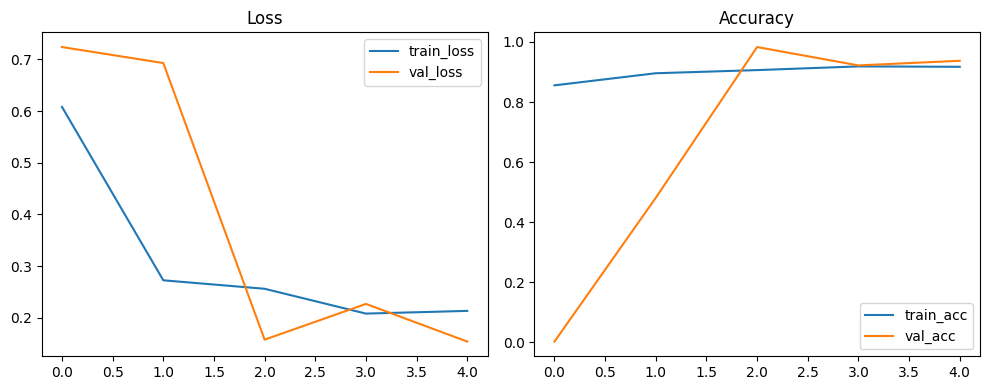

In [51]:
# 10. 训练曲线/Training curve
# ============================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy")

plt.tight_layout()
plt.show()

# 11. Threshold sweep on the validation set

By default, binary classifiers use **0.5** as the decision threshold:  
- probability ≥ 0.5 → wildfire (1)  
- probability < 0.5 → no wildfire (0)

But 0.5 is not always the best choice, especially when the classes are slightly imbalanced or when we care more about detecting wildfires. Here we **scan a range of thresholds** (0.3 → 0.7) on the **validation set** and pick the one that gives the highest accuracy.


In [52]:
# 11. 验证集扫阈值，找更好的 accuracy/Verify the threshold for the set scan and find better accuracy.
# ============================================
all_true, all_prob = [], []
for i, (imgs, labels) in enumerate(val_ds.take(VAL_STEPS)):
    probs = model.predict(imgs, verbose=0).flatten()
    all_prob.extend(list(probs))
    all_true.extend(list(labels.numpy().astype(int)))

all_true = np.array(all_true)
all_prob = np.array(all_prob)

best_acc = 0.0
best_th = 0.5
for th in np.linspace(0.3, 0.7, 21):
    pred = (all_prob >= th).astype(int)
    acc = (pred == all_true).mean()
    if acc > best_acc:
        best_acc = acc
        best_th = th

print("Best val acc:", best_acc, "at threshold", best_th)

Best val acc: 0.95875 at threshold 0.7


# 12. Confusion matrix with the best threshold

After we find the best validation threshold (`best_th`), we apply it to the **test set** to see how the model actually performs on unseen data. A confusion matrix helps us answer:

- How many wildfire images did we correctly detect? (TP)
- How many wildfire images did we miss? (FN)
- How many no-wildfire images did we correctly reject? (TN)
- How many no-wildfire images did we incorrectly flag as wildfire? (FP)

This is especially important for wildfire tasks, because **FN (missed fires)** are usually more critical than FP.


2025-11-08 07:26:10.693154: E tensorflow/core/lib/jpeg/jpeg_mem.cc:329] Premature end of JPEG data. Stopped at line 126/350


Confusion matrix:
 [[2746   74]
 [ 324 3124]]


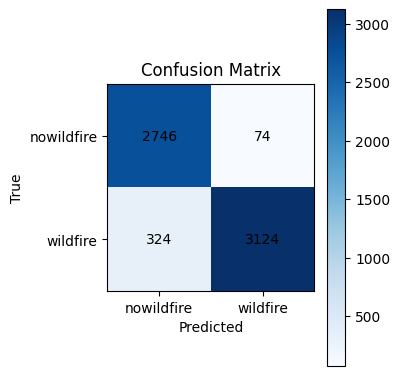

In [53]:
# 12. 用最优阈值做混淆矩阵/Use the optimal threshold to construct the confusion matrix.
# ============================================
y_true, y_pred = [], []
for imgs, labels in test_ds:
    probs = model.predict(imgs, verbose=0).flatten()
    pred = (probs >= best_th).astype(int)
    y_pred.extend(list(pred))
    y_true.extend(list(labels.numpy().astype(int)))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = [0, 1]
plt.xticks(ticks, class_names)
plt.yticks(ticks, class_names)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Compare with the original CNN

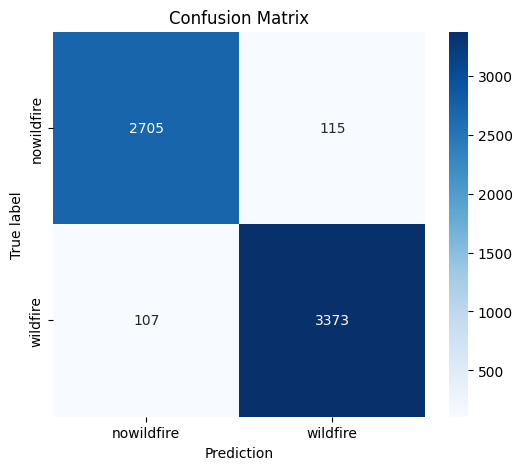

              precision    recall  f1-score   support

  nowildfire       0.96      0.96      0.96      2820
    wildfire       0.97      0.97      0.97      3480

    accuracy                           0.96      6300
   macro avg       0.96      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300



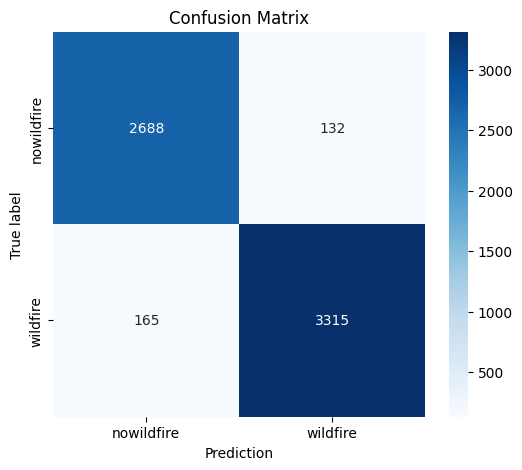

              precision    recall  f1-score   support

  nowildfire       0.94      0.95      0.95      2820
    wildfire       0.96      0.95      0.96      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



In [39]:
# Compare with the original CNN model 
class_report(true_classes, predicted_classes, class_labels)
class_report(true_classes3, predicted_classes3, class_labels3) # Model 3

# 13. Randomly visualize test predictions

To avoid always looking at the **first** test batch (which may contain only one class), we can randomly skip several batches from `test_ds` and then plot the predictions from the next batch. This helps us inspect more diverse satellite images and see how the model behaves on different parts of the test set.

What this code does:

1. Randomly pick a number between 0 and `MAX_SKIP`.
2. Skip that many batches from `test_ds`.
3. On the first batch after skipping, run the model, apply the chosen threshold, and plot up to 8 images with their **true label (T: )** and **predicted label (P: )**.


Randomly skipping 9 batches from test_ds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


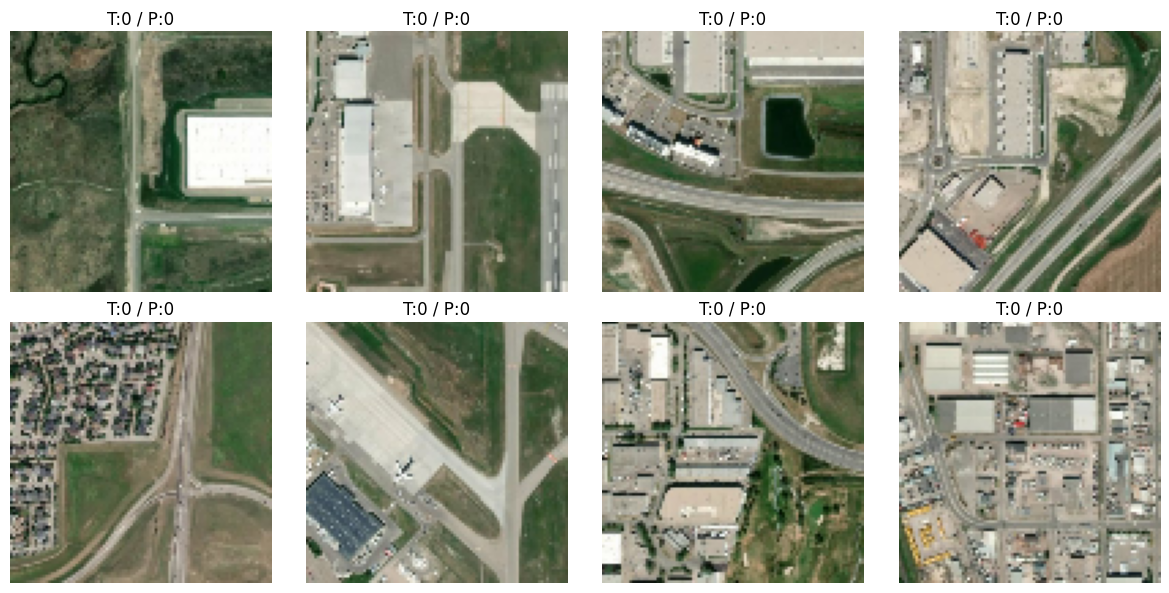

In [87]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# 想要最多跳过多少批/How many batches can be skipped at most randomly
MAX_SKIP = 40
skip = random.randint(0, MAX_SKIP)
print(f"Randomly skipping {skip} batches from test_ds...")

current = 0
for imgs, labels in test_ds:
    if current < skip:
        current += 1
        continue

    
    # 预测/predict
    probs = model.predict(imgs).flatten()
    thresh = best_th if "best_th" in globals() else 0.5
    preds = (probs >= thresh).astype(int)

    # 去掉时间维度 (B, H, W, C)/Remove the time dimension (B, H, W, C)
    imgs = tf.squeeze(imgs, axis=1)

    plt.figure(figsize=(12, 6))
    n_show = min(8, imgs.shape[0])
    for i in range(n_show):
        plt.subplot(2, 4, i + 1)
        pic = (imgs[i].numpy() * 255).astype("uint8")
        plt.imshow(pic)

        # 兼容 (1,) 或标量的 label
        lbl_arr = labels[i].numpy()
        true_label = int(lbl_arr[0]) if lbl_arr.ndim > 0 else int(lbl_arr)

        pred_label = int(preds[i])
        plt.title(f"T:{true_label} / P:{pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break 
